# Dataset Analysis Demo

This notebook demonstrates how to use the high-level analysis tooling from OG-MARL to inspect datasets.

In [1]:
from og_marl.vault_utils.download_vault import *
from og_marl.vault_utils.analyse_vault import analyse_vault
from flashbax.vault import Vault
import jax
from og_marl.vault_utils.subsample_smaller import subsample_smaller_vault
from og_marl.vault_utils.subsample_similar import subsample_similar
from og_marl.vault_utils.combine_vaults import combine_vaults
from og_marl.vault_utils.analyse_vault import full_analysis

## Download a vault and get to know the file structure
### OG-MARL vault file structure

In [2]:
print_download_options()

{'cfcql': {'smac_v1': {'2s3z': {...},
                       '3s_vs_5z': {...},
                       '5m_vs_6m': {...},
                       '6h_vs_8z': {...}}},
 'og_marl': {'mamujoco': {'2halfcheetah': {...}},
             'smac_v1': {'2s3z': {...},
                         '3m': {...},
                         '3s5z_vs_3s6z': {...},
                         '5m_vs_6m': {...},
                         '8m': {...}},
             'smac_v2': {'terran_5_vs_5': {...}, 'zerg_5_vs_5': {...}}}}


We can either choose a source-environment-task combination from those available above, or we can specify our source-environment-task combination and input our own url for downloading the (zipped) vault.

In [3]:
source = 'og_marl'
env = 'smac_v1'
task = '2s3z'

rel_vault_location = download_and_unzip_vault(source,env,task)
_ = download_and_unzip_vault(source,env,'didi',dataset_download_url="dipidipidababa") #trying to download from a nonsense url will not work

Vault './vaults/og_marl/smac_v1/2s3z' already exists.
Dataset from dipidipidababa could not be downloaded. Try entering a different URL, or removing the part which auto-downloads.


We have now downloaded our vault into a folder ".vaults/{source}/{env}/{task}.vlt", if it didn't already exist. The vault may contain multiple datasets, each with a unique identifier, or UID.

In [4]:
print(rel_vault_location)
vault_uids = get_available_uids(rel_vault_location)
print(vault_uids)

./vaults/og_marl/smac_v1/2s3z.vlt
['Poor', 'Medium', 'Good']


So the folder ".vaults/og_marl/smac_v1/2s3z.vlt" contains a "Good", "Medium" and "Poor" dataset, each in their own folder.

### OG-MARL vault file structure to Vault file structure
The datasets from OG-MARL are placed in a file structure for maximum information retention about the dataset, which is why we talk about source, env, task and uid. Vault distinguishes only between three path components: the relative directory in which the vault sits, the vault name, and the vault uid.

In [5]:
vault_rel_dir = f"vaults/{source}/{env}" # combine base vault directory with the dataset source and environment folders
vault_name = f"{task}.vlt" # a vault name contains only the file name which has the .vlt extension
vault_uid = vault_uids[0] # we select the first dataset in the vault

vlt = Vault(rel_dir=vault_rel_dir, vault_name=vault_name, vault_uid=vault_uid)

Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Poor


For further information about a Vault's api, please see the dataset api demo.

## Subsample a vault
OG-MARL provides tooling for subsampling a vault, in the case where working with a large vault is intractable, or if you just want a smaller vault. This *creates a new vault* so keep an eye on your storage when making lots of subsampled vaults.

#### Uniformly subsampling episodes to a desired number of transitions
We uniformly subsample episodes to within an episode of the desired number of transitions (this is to avoid subsampling partial episodes, since we often work with episode returns of a dataset and a partial episode provides an inaccurate return value).

If you try to subsample an amount of transitions greater than the contents of the vault, this function will simply return a copy of the vault with the episodes shuffled, which is a potential if inefficient use case of this function.

First, we see how big a dataset is.

In [6]:
all_data = vlt.read()
offline_data = all_data.experience
jax.tree_map(lambda x: x.shape, offline_data)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


{'actions': (1, 996418, 5),
 'infos': {'legals': (1, 996418, 5, 11), 'state': (1, 996418, 120)},
 'observations': (1, 996418, 5, 80),
 'rewards': (1, 996418, 5),
 'terminals': (1, 996418, 5),
 'truncations': (1, 996418, 5)}

Now that we know how many transitions are in the dataset (the second value), we can make a good choice of size for subsampling.

Vault 'vaults/og_marl/smac_v1/2s3z_20000' already exists. To subsample from scratch, please remove the current subsampled vault from its directory.
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_20000.vlt/Poor
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_20000.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_20000.vlt/Good


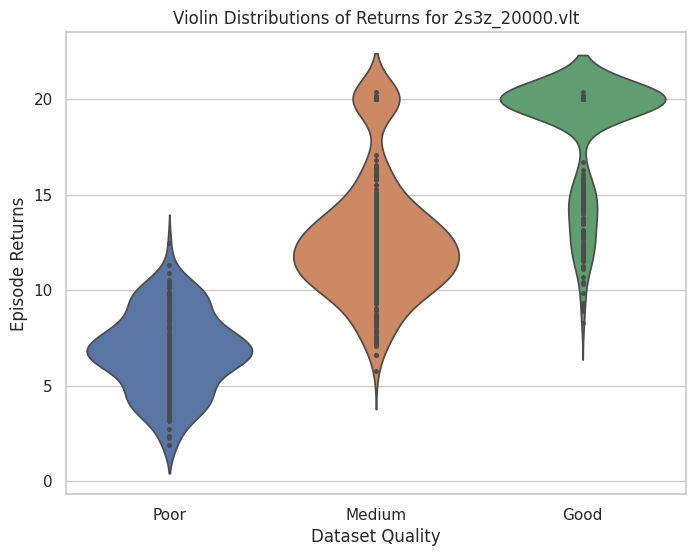

In [7]:
n_transitions = 20000

# we can specify a list with just one uid to subsample only one, but automatically it subsamples each dataset in the vault
new_vault_name = subsample_smaller_vault(vault_rel_dir,vault_name,target_number_of_transitions=n_transitions)

new_vault_name = task+'_'+str(n_transitions)+'.vlt'

returns = analyse_vault(vault_name=new_vault_name, rel_dir=vault_rel_dir, visualise=True)

### Subsampling two vaults to have similar episode return  distributions

We also have utility to subsample two vaults so that their episode return distributions are as similar as possible. The result should have a episode return distributions that look like the intersection of the original distributions.

For the "2s3z" vaults subsampled above, we see that there is overlap between the "Medium" and "Good" vaults. Let's try to subsample them similarly.

Vault 'vaults/og_marl/smac_v1/2s3z_similarly_subsampled' already exists. To subsample from scratch, please remove the current subsampled vault from its directory.
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_similarly_subsampled.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_similarly_subsampled.vlt/Good


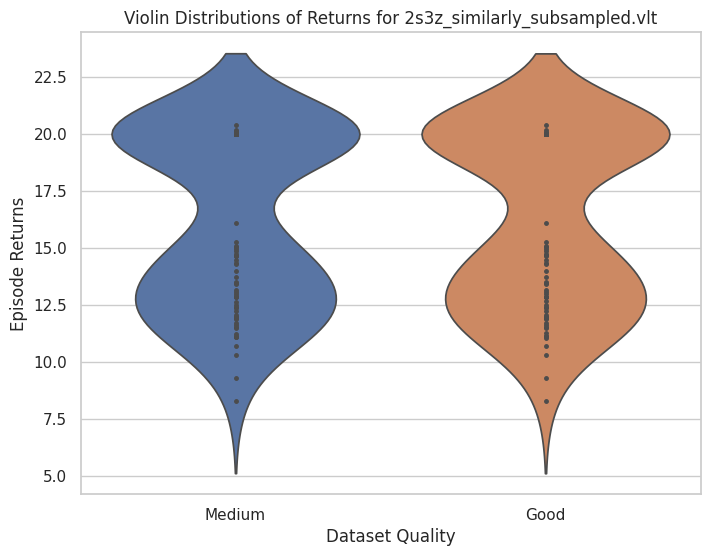

In [8]:
medium_vault_info = {
    "rel_dir": vault_rel_dir,
    "vault_name":new_vault_name,
    "uid": 'Medium',
}
good_vault_info = {
    "rel_dir": vault_rel_dir,
    "vault_name":new_vault_name,
    "uid": 'Good',
}

subsampled_vault_name = f"{task}_similarly_subsampled.vlt"
# we can specify a list with just one uid to subsample only one, but automatically it subsamples each dataset in the vault
subsample_similar(medium_vault_info,good_vault_info,vault_rel_dir,subsampled_vault_name)

returns = analyse_vault(vault_name=subsampled_vault_name, rel_dir=vault_rel_dir, visualise=True)

### Combine datasets in a vault

We present utilities to combine datasets within a vault. To test, we combine the smaller subsampled vaults.

Vault 'vaults/og_marl/smac_v1/2s3z_20000_combined' already exists. To combine from scratch, please remove the current combined vault from its directory.
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_20000_combined.vlt/Poor_Medium_Good


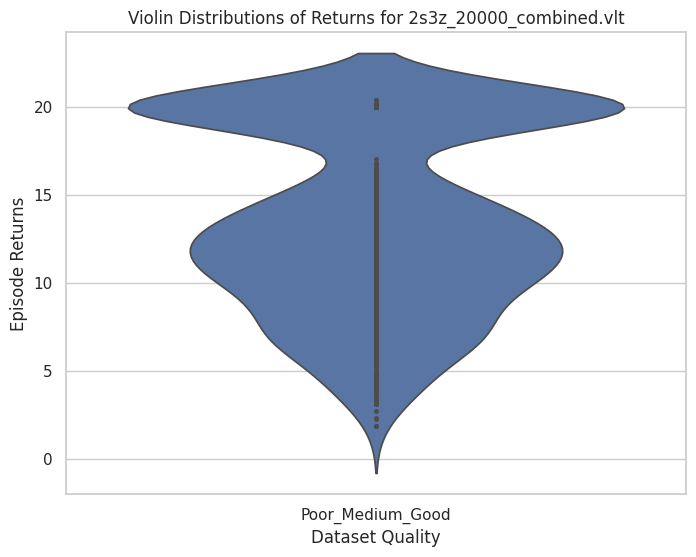

In [9]:
comb_vault_name = combine_vaults(vault_rel_dir,new_vault_name)

comb_vault_name = f"{new_vault_name.strip('.vlt')}_combined.vlt"

returns = analyse_vault(vault_name=comb_vault_name, rel_dir=vault_rel_dir, visualise=True)

### In a most detailed way, subsample a vault (TODO)

Given a histogram of episode returns, we allow subsampling a vault according to the histogram in a flexible way. That is, we allow individul specification of the size of each bucket.

We do not allow the bucket size to be larger than what exists in the subsampled datasets - you can change the function to work this way, but the effect is not necessarily what one might want. Especially with State-Action coverage in mind.

In [10]:
# def get_histogram_for_subsampling

# (prints hist and the values)

## Vault analysis

The analysis tool we have been using so far is a summary, the goal of which is to give a quick overview of a dataset's episode returns to verify that subsampling worked as it should.

We do, however, provide more extensive tools for analysis. 

Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Poor
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Good
Uid         Mean    Stddev    Transitions    Trajectories    Joint SACo
------  --------  --------  -------------  --------------  ------------
Poor     6.87636   2.06233         996418            9942      0.960472
Medium  12.567     3.14207         996256           18605      0.98416
Good    18.3202    2.95182         995829           18616      0.984996


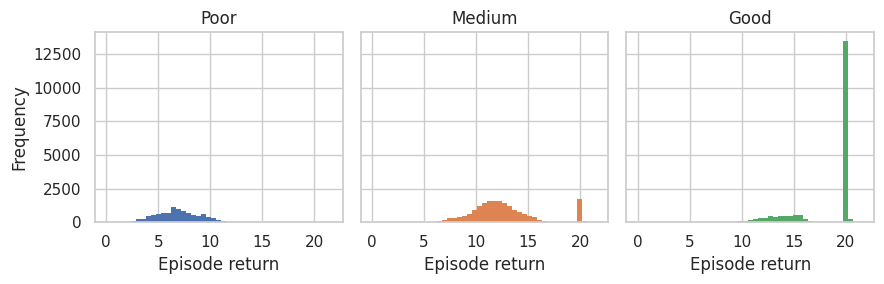

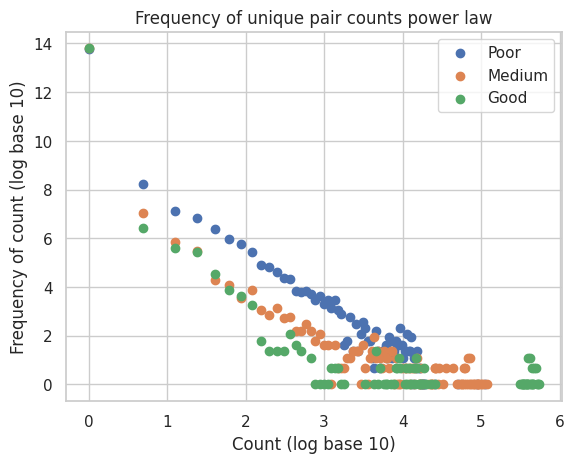

In [11]:
info = full_analysis(vault_name="2s3z.vlt",rel_dir=vault_rel_dir,n_bins=45)